In [1]:
import datetime, time
import numpy as np
import pandas as pd
from scipy import stats
import os
import subprocess

In [2]:
#Extract the list of companies
sp = np.genfromtxt(os.path.join('./sims_final', 'companies_final.csv'), delimiter=',', dtype=None)


In [3]:
#Separate into tickers, industries, etc.
tickers = sp[:,0]
industries = sp[:,1]

samples = tickers.size

#Lists where we will store information extracted from the sims
states = []
for i in range(0,12):
    states.append(np.zeros(samples))

In [4]:

ticker_sub = tickers[:samples]
industry_sub = industries[:samples]
companies_sub = np.vstack((ticker_sub,industry_sub))

In [5]:

#This function is used to simulate investments by percentage probability of remaining in starting state

def invest(threshold):
    
    n=0
    e=0

    pd.options.display.float_format = '{:,.4f}'.format
    th = 0.42
    for t,i in zip(companies_sub[0,:],companies_sub[1,:]):

        try:
            fname = "Predictions_" + str(t) + "_States_1_stats.csv"
            data = np.genfromtxt(os.path.join('./sims_final', fname), delimiter=',', dtype=None)
            err = data[2]
            var = data[4]
            med = data[5]
            stop = data[3]
            avg_pr1 = data[0]
            rp = data[1]
            stp = rp[0]

            if (err.size >1):

                stop = stop[-1]

                if ((int(np.log(th)/np.log(stop)))>=364):
                    continue

                if (stop ==1):
                    stop = -1
                else:
                    stop = int(np.log(threshold)/np.log(stop))


                err = err[stop]
                var =  var[stop]
                med = med[stop]
                avg_pr1 = avg_pr1[stop]
                rp = rp[stop]

            states[0][n] = err
            states[2][n] = var
            states[4][n] = med







            fname = "Predictions_" + str(t) + "_States_5_stats.csv"
            data = np.genfromtxt(os.path.join('./sims_final', fname), delimiter=',', dtype=None)
            err = data[2]
            var = data[4]
            med = data[5]
            stop = data[3]
            avg_pr5 = data[0]

            if (err.size >1):

                stop = stop[-1]

                if ((int(np.log(th)/np.log(stop)))>=364):
                    continue

                if (stop ==1):
                    stop = -1
                else:
                    stop = int(np.log(threshold)/np.log(stop))


                err = err[stop]
                var =  var[stop]
                med = med[stop]
                avg_pr5 = avg_pr5[stop]


            states[1][n] = err
            states[3][n] = var
            states[5][n] = med

            states[6][n] = rp
            states[7][n] = avg_pr1
            states[8][n] = avg_pr5
            
            if (stop == -1):
                stop = 1
            
            states[9][n] = stop
            stop_avg = np.mean(states[9])
            
            states[10][n] = stp

            n=n+1

        except:
            #print (t)
            e = e+1




    for i in range(0,12):
        states[i] = states[i][:n]



    dfr = pd.DataFrame({  
                        'err1' : states[0]/states[6],
                        'err5' : states[1]/states[6],
                        'error 1 state' : np.absolute(states[0]/states[6]),
                        'error 5 states' : np.absolute(states[1]/states[6]),
                        'sqe 1 state' : np.square(states[0]/states[6]),
                        'sqe 5 states' : np.square(states[1]/states[6]),
                        'median 1 state' : np.absolute(states[4]-states[6]),
                        'median 5 states' : np.absolute(states[5]-states[6]),
                        'delta': np.absolute(states[0]/states[6]) - np.absolute(states[1]/states[6]),
                        'start price error':np.absolute(states[6]-states[10])/states[6],
                        'expected gain1': states[7]>states[10],
                        'expected gain5': states[8]>states[10],
                        'normalised real gain/loss': (states[6]-states[10])/states[10],
                         })

    invest1 = dfr[dfr['expected gain1'] == True]['normalised real gain/loss'].values
    gain1 = np.sum(invest1)
    companies_inv1 = invest1.size

    invest5 = dfr[dfr['expected gain5'] == True]['normalised real gain/loss'].values
    gain5 = np.sum(invest5)
    companies_inv5 = invest5.size

    do_not_invest5 = dfr[dfr['expected gain5'] == False]['normalised real gain/loss'].values

    alt_gain5 = np.sum(do_not_invest5)

    companies_alt5 = do_not_invest5.size

    return gain5, companies_inv5, alt_gain5, companies_alt5, stop_avg, gain1, companies_inv1

In [6]:
#Test
invest(.5)

(10.688047747554641,
 281,
 2.7201929402664389,
 133,
 25.071770334928228,
 11.897852585480374,
 300)

In [7]:
def inv(m):
    return [invest(i) for i in m]

In [8]:
m = np.linspace(1,.5,24)


result_m = inv(m)

In [9]:
#Separate results into component arrays
m_len = len(result_m)
result_gain5 = np.array([result_m[i][0] for i in xrange(m_len)])
result_companies_inv5 = np.array([result_m[i][1] for i in xrange(m_len)])
result_alt_gain = np.array([result_m[i][2] for i in xrange(m_len)])
result_companies_alt = np.array([result_m[i][3] for i in xrange(m_len)])
result_avg_days = np.array([result_m[i][4] for i in xrange(m_len)])
result_gain1 = np.array([result_m[i][5] for i in xrange(m_len)])
result_companies_inv1 = np.array([result_m[i][6] for i in xrange(m_len)])

In [11]:
#Configure Matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

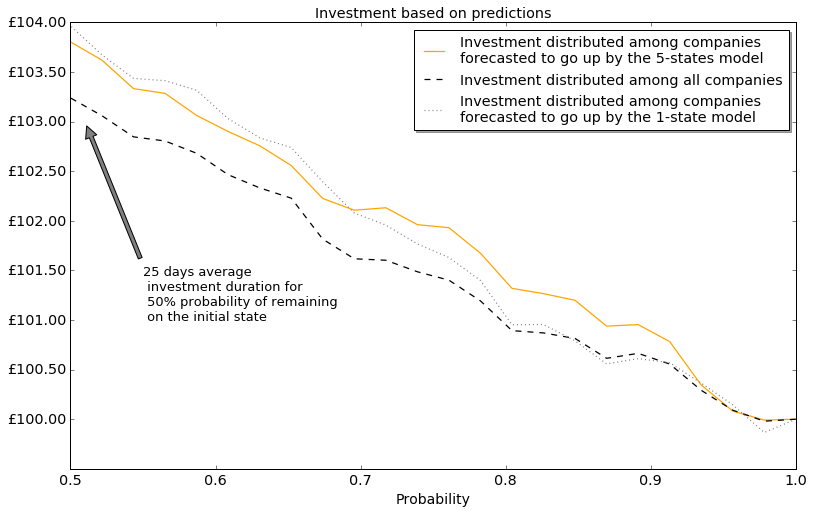

In [62]:

pound = u'\u00A3'
investment = 100
fig = plt.figure(figsize=(13,8))
plt.title("Investment based on predictions")
#plt.ylabel(pound, fontsize=18)
plt.xlabel("Probability", fontsize=14)
ax = fig.add_subplot(1, 1, 1)
ax.plot(m,investment*(1+result_gain5/result_companies_inv5),color="orange",linewidth=1.25, linestyle="-",
        label='Investment distributed among companies \nforecasted to go up by the 5-states model')
ax.plot(m,investment*(1+(result_alt_gain+result_gain5)/(result_companies_inv5 + result_companies_alt)),color="black",
        linewidth=1.25, linestyle="--", label='Investment distributed among all companies')
ax.plot(m,investment*(1+result_gain1/result_companies_inv1),color="grey",linewidth=1.25, linestyle=":",
        label='Investment distributed among companies \nforecasted to go up by the 1-state model')
plt.xlim([0.5,1])
ax.yaxis.set_major_locator(mticker.MaxNLocator(prune='lower'))
ax.legend(loc='best', shadow=True)
ax.annotate('25 days average \n investment duration for \n 50% probability of remaining \n on the initial state', 
            xy=(.51, 103), xytext=(.55, 101), fontsize=13,
            arrowprops=dict(facecolor='grey', shrink=0.03),
            )
vals = ax.get_yticks()
ax.set_yticklabels([u'\u00A3''{:3.2f}'.format(x) for x in vals])
plt.savefig('Investment_based_on_predictions.png',bbox_inches='tight')
plt.show()
#ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])

In [17]:
# Function to graph MAE by probability
def prob_graph(threshold):
    n=0
    th = 0.42
    for t,i in zip(companies_sub[0,:],companies_sub[1,:]):

        try:
            fname = "Predictions_" + str(t) + "_States_1_stats.csv"
            data = np.genfromtxt(os.path.join('./sims_final', fname), delimiter=',', dtype=None)
            err = data[2]
            var = data[4]
            med = data[5]
            stop = data[3]
            avg_pr1 = data[0]
            rp = data[1]
            stp = rp[0]

            if (err.size >1):

                stop = stop[-1]
                if ((int(np.log(th)/np.log(stop)))>=364):
                    continue

                if (stop ==1):
                    stop = -1
                else:
                    stop = int(np.log(threshold)/np.log(stop))


                err = err[stop]
                var =  var[stop]
                med = med[stop]
                avg_pr1 = avg_pr1[stop]
                rp = rp[stop]

            states[0][n] = err
            states[2][n] = var
            states[4][n] = med



            fname = "Predictions_" + str(t) + "_States_5_stats.csv"
            data = np.genfromtxt(os.path.join('./sims_final', fname), delimiter=',', dtype=None)
            err = data[2]
            var = data[4]
            med = data[5]
            stop = data[3]
            avg_pr5 = data[0]

            if (err.size >1):

                stop = stop[-1]
                if ((int(np.log(th)/np.log(stop)))>=364):
                    continue

                if (stop ==1):
                    stop = -1
                else:
                    stop = int(np.log(threshold)/np.log(stop))

                err = err[stop]
                var =  var[stop]
                med = med[stop]
                avg_pr5 = avg_pr5[stop]


            states[1][n] = err
            states[3][n] = var
            states[5][n] = med

            states[6][n] = rp
            states[7][n] = avg_pr1
            states[8][n] = avg_pr5
            
            
            if (stop == -1):
                stop = 1
            
            states[9][n] = stop
            stop_avg = np.mean(states[9])

            states[10][n] = stp
            
            n=n+1

        except:

            pass
    
    for i in range(0,12):
        states[i] = states[i][:n]
    
    e0 = np.absolute(states[10]-states[6])/states[6]
    
    e1 = np.absolute(states[0]/states[6])
    e5 = np.absolute(states[1]/states[6])
    
    s_val, p_val = stats.wilcoxon(e1,e5)
       
    mse =  (np.sqrt(np.average(np.square(e0))),
        np.sqrt(np.average(np.square(e1))), 
        np.sqrt(np.average(np.square(e5))), 
           stop_avg) 
        
 
        
    abs_err = (np.average(e0), np.average(e1), np.average(e5), stop_avg, 
               np.var(e0),
               np.var(e1),
               np.var(e5))
        
    return abs_err, mse, p_val
    
    

In [19]:
def gr(x):
    return [prob_graph(e) for e in x]

In [ ]:
x = np.linspace(0.50,1,100)


result = gr(x)

In [21]:
r_len = len(result)
result_avg = [result[i][0] for i in xrange(r_len)]
result_mse = [result[i][1] for i in xrange(r_len)]
result_pval = [result[i][2] for i in xrange(r_len)]
result_pval = np.array(result_pval)

In [22]:
d_gr = [result_avg[j][3] for j in range(r_len)]

In [23]:
### Regions where p < 0.01
lims2 = np.where(result_pval < 0.01)
print (lims2[0])

[62 63 69 70]


In [24]:
### Regions where p < 0.05
lims = np.where(result_pval < 0.05)
print (lims[0])

[51 52 53 60 61 62 63 64 65 67 68 69 70 71 75 76]


In [25]:
gr0 = [result_avg[j][0] for j in range(r_len)]
gr1 = [result_avg[j][1] for j in range(r_len)]
gr5 = [result_avg[j][2] for j in range(r_len)]
err0 = [result_avg[j][4] for j in range(r_len)]
err1 = [result_avg[j][5] for j in range(r_len)]
err5 = [result_avg[j][6] for j in range(r_len)]

In [26]:
gr0 = np.array(gr0)
gr1 = np.array(gr1)
gr5 = np.array(gr5)

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)



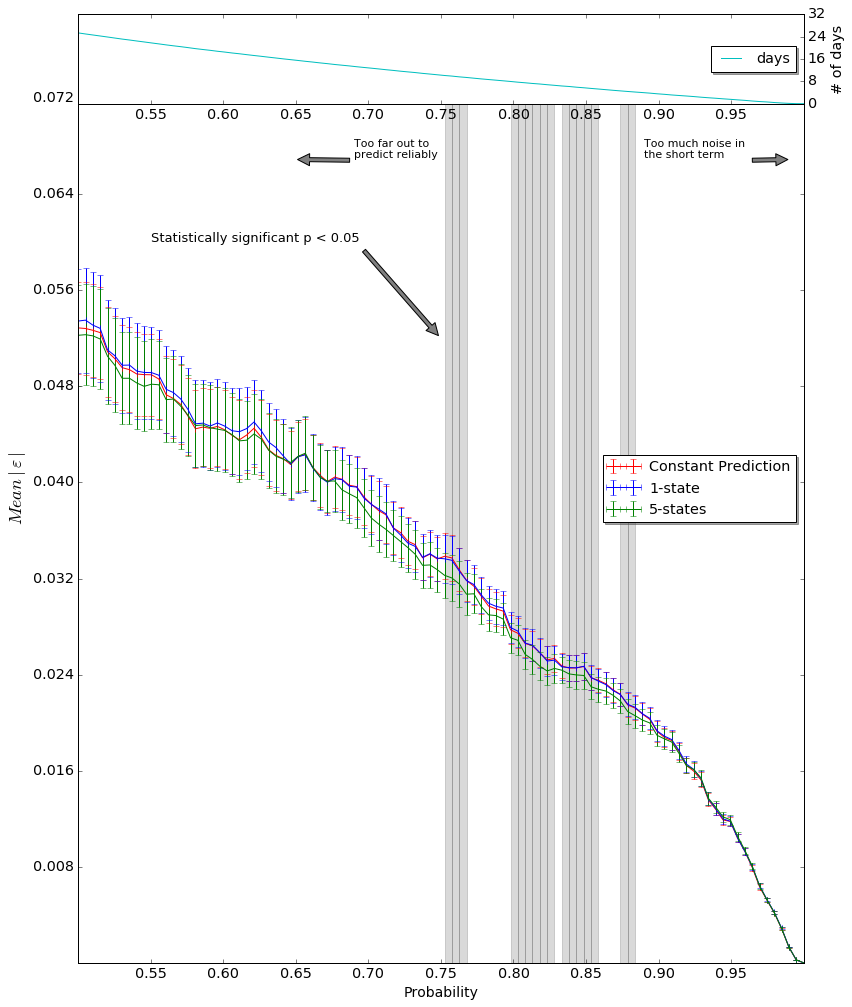

In [60]:
fig = plt.figure(figsize=(13, 17))
ax1 = fig.add_subplot(1, 1, 1)
#plt.title("Accuracy as probability of still being in starting state")
plt.ylabel(r'$Mean \mid \varepsilon \mid$', fontsize=18)
plt.xlabel("Probability", fontsize=14)
ax1.errorbar(x,gr0,xerr=0.0, yerr=err0, label='Constant Prediction',color="red")
ax1.errorbar(x,gr1,xerr=0.0, yerr=err1, label='1-state',color="blue")
ax1.errorbar(x,gr5,xerr=0.0, yerr=err5, label='5-states',color="green") 
#ax1.plot(x,result_pval, color="yellow")
for s in range(len(lims[0])):
    ax1.axvspan(x[lims[0][s]-1], x[lims[0][s]],color = '0.0',alpha=0.15)
ax1.yaxis.set_major_locator(mticker.MaxNLocator(prune='both'))
ax1.set_autoscaley_on(True)
ax1.legend(loc='right', shadow=True)
ax1.yaxis.set_major_locator(mticker.MaxNLocator(5))
plt.xlim([0.51,1])
plt.ylim([0,0.079])
ax1.yaxis.set_major_locator(mticker.MaxNLocator(prune='both'))
ax1.xaxis.set_major_locator(mticker.MaxNLocator(prune='both'))


ax2 = fig.add_subplot(9, 1, 1, sharex=ax1)
ax2.plot(x,d_gr,'c', label='days')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel("# of days")
ax1.legend(loc='center right', shadow=True)
ax2.legend(loc='center right', shadow=True)
ax2.xaxis.set_major_locator(mticker.MaxNLocator(14))
ax2.xaxis.set_major_locator(mticker.MaxNLocator(prune='both'))
ax2.yaxis.set_major_locator(mticker.MaxNLocator(5))
plt.xlim([0.5,1])
plt.ylim([0,32])
plt.xticks(np.arange(min(x)+.05, max(x), 0.05))
ax1.annotate('Statistically significant p < 0.05', xy=(.75, .052), xytext=(.55, .060), fontsize=13,
            arrowprops=dict(facecolor='grey', shrink=0.03),
            )
ax1.annotate('Too far out to \npredict reliably', xy=(.65, .0669), xytext=(.69, .067), fontsize=11,
            arrowprops=dict(facecolor='grey', shrink=0.03),
            )
ax1.annotate('Too much noise in \nthe short term', xy=(.99, .0669), xytext=(.89, .067), fontsize=11,
            arrowprops=dict(facecolor='grey', shrink=0.03),
            )
plt.savefig('Accuracy_as_percentage.png',bbox_inches='tight')
plt.show()

In [32]:
#Function to graph by days
def days_graph(num_days):
    n=0
    for t,i in zip(companies_sub[0,:],companies_sub[1,:]):

        try:
            fname = "Predictions_" + str(t) + "_States_1_stats.csv"
            data = np.genfromtxt(os.path.join('./sims_final', fname), delimiter=',', dtype=None)
            err = data[2]
            var = data[4]
            med = data[5]
            stop = num_days
            avg_pr1 = data[0]
            rp = data[1]
            stp = rp[0]

            if (err.size >1):

                err = err[stop]
                var =  var[stop]
                med = med[stop]
                avg_pr1 = avg_pr1[stop]
                rp = rp[stop]

            states[0][n] = err
            states[2][n] = var
            states[4][n] = med



            fname = "Predictions_" + str(t) + "_States_5_stats.csv"
            data = np.genfromtxt(os.path.join('./sims_final', fname), delimiter=',', dtype=None)
            err = data[2]
            var = data[4]
            med = data[5]

            avg_pr5 = data[0]

            if (err.size >1):

                err = err[stop]
                var =  var[stop]
                med = med[stop]
                avg_pr5 = avg_pr5[stop]


            states[1][n] = err
            states[3][n] = var
            states[5][n] = med

            states[6][n] = rp
            states[7][n] = avg_pr1
            states[8][n] = avg_pr5

            states[10][n] = stp
            
            n=n+1

        except:

            pass
    
    for i in range(0,12):
        states[i] = states[i][:n]
    
    e0 = np.absolute(states[10]-states[6])/states[6]
    
    e1 = np.absolute(states[0]/states[6])
    e5 = np.absolute(states[1]/states[6])     
 
    s_val, p_val = stats.wilcoxon(e1,e5)
        
    abs_err = (np.average(e0), np.average(e1), np.average(e5),  
               np.var(e0),
               np.var(e1),
               np.var(e5))
        
    return abs_err, p_val

In [33]:
results_days = days_graph(0)

In [34]:
def gr_days(x):
    return [days_graph(e) for e in x]

In [35]:
x_days = range(0,90,1)
#x_days = np.concatenate([[0,1,2,3,4,5,6,7,8,9,10],x_days])

In [36]:
result_days = gr_days(x_days)

In [37]:
result_days_avg = [result_days[i][0] for i in xrange(len(result_days))]
result_pval_days = [result_days[i][1] for i in xrange(len(result_days))]
result_pval_days = np.array(result_pval_days)

In [38]:
#Regions with p < 0.01
lims_days = np.where(result_pval_days <= 0.05)
print (lims_days[0])

[ 7  8  9 10 11 12 19 22 84 88]


In [39]:
# Break results into component arrays
r_len_days = len(result_days)
gr0_days = [result_days_avg[j][0] for j in range(r_len_days)]
gr1_days = [result_days_avg[j][1] for j in range(r_len_days)]
gr5_days = [result_days_avg[j][2] for j in range(r_len_days)]
err0_days = [result_days_avg[j][3] for j in range(r_len_days)]
err1_days = [result_days_avg[j][4] for j in range(r_len_days)]
err5_days = [result_days_avg[j][5] for j in range(r_len_days)]

err0_days=np.array(err0_days)
err1_days=np.array(err1_days)
err5_days=np.array(err5_days)

gr0_days = np.array(gr0_days)
gr1_days = np.array(gr1_days)
gr5_days = np.array(gr5_days)

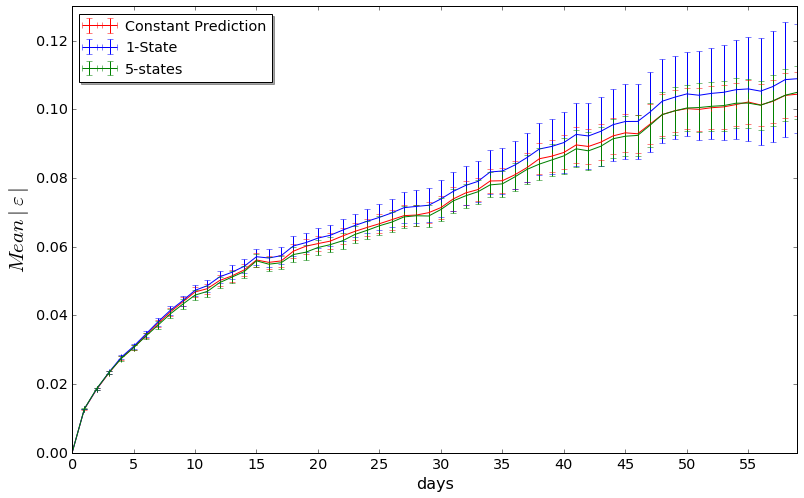

In [40]:
plt.figure(figsize=(13, 8))
#plt.title("Accuracy n days out")
plt.ylabel(r'$Mean \mid \varepsilon \mid$', fontsize=21)
plt.xlabel("days", fontsize=16)
#for s in range(len(lims_days[0])):
#    plt.axvspan(x_days[lims_days[0][s]-1], x_days[lims_days[0][s]],color = '0.0',alpha=0.2)
plt.errorbar(x_days,gr0_days, xerr=0.0, yerr=err0_days, label='Constant Prediction',color="red")
plt.errorbar(x_days,gr1_days, xerr=0.0, yerr=err1_days, label='1-State',color="blue")
plt.errorbar(x_days,gr5_days, xerr=0.0, yerr=err5_days, label='5-states',color="green")
plt.xticks(np.arange(min(x_days), max(x_days), 5))
plt.xlim([0,59])
plt.ylim([0,.13])
plt.legend(loc='best', shadow=True)
plt.savefig('Accuracy_days.png',bbox_inches='tight')
plt.show()

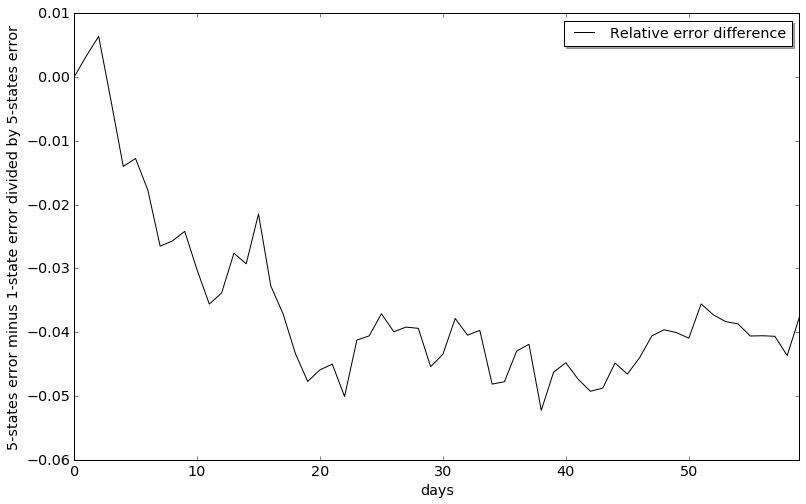

In [41]:
plt.figure(figsize=(13, 8))
#plt.title("Accuracy n days out")
plt.ylabel("5-states error minus 1-state error divided by 5-states error")
plt.xlabel("days")
plt.plot(x_days,(gr5_days - gr1_days)/gr5_days, label='Relative error difference',color="black")
plt.legend(loc='best', shadow=True)
plt.xlim([0,59])
plt.savefig('relative_error.png',bbox_inches='tight')
plt.show()